# Proyecto 3 - Aprendizaje no supervisado

- Juan Ignacio Navarro
- Jose David Sánchez
- Steven Badilla

In [119]:
"""
Used libraries for the entire project
"""
import os
import numpy as np
import pandas as pd
from PIL import Image
import random 
import shutil
import matplotlib.pyplot as plt
import time
import optuna

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, MaxPooling2D, UpSampling2D, Reshape
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve



## Feature engineering

Set de datos llamado Plant_leaf_deseases_dataset_without_augmentation: https://data.mendeley.com/datasets/tywbtsjrjv/1

### Crop and fix Bias in images dataset

In [ ]:
"""
-- Delete unnecessary images --

These background images do not help the model on anything
"""

os.remove("images/original_dataset/Background_without_leaves")

In [9]:
"""
-- Delete images from cropped dataset --

This cell deletes the files in the cropped dataset if any. The
cropped dataset a cropped copy from the additional dataset images.
The images are cropped to show only the most important part of 
the leaves which is the center
"""

cropped_images_folder = 'images/cropped_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files in each category
for category in categories.keys():

    folder_path = os.path.join(cropped_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(cropped_images_folder, category, file_name)
        os.remove(file_path)

In [10]:
"""
-- Crop images borders -- 

This block crops the images borders and saves the new images into the cropped_dataset
"""

# define a different folder to save the cropped images
original_images_folder = 'images/original_dataset/'
analysis_images_folder = 'images/cropped_dataset/'

# define the new size
target_size = (100, 100)

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(original_images_folder))):
    folder_path = os.path.join(original_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# Create category folders in cropped dataset
for index, folder_name in enumerate(sorted(os.listdir(original_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)

# crop and save the cropped images
for category in categories.keys():

    cat_files = os.listdir(os.path.join(original_images_folder, category))

    for i, file in enumerate(cat_files):

        # constructing image path
        input_path = os.path.join(original_images_folder, category, file)
        image = Image.open(input_path)

        if image.size[0] < 256 or image.size[1] < 256:
            continue
        
        # get original image size and calculate borders
        width, height = image.size
        left = (width - target_size[0]) // 2
        upper = (height - target_size[1]) // 2
        right = left + target_size[0]
        lower = upper + target_size[1]

        # crop the image
        cropped_image = image.crop((left, upper, right, lower))
        output_path = os.path.join(cropped_images_folder, category, file)
        cropped_image.save(output_path)
        image.close()

In [11]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""

cropped_images_folder = 'images/cropped_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

# Print the information taken
print("Amount of images in analysis dataset:")
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    print(f"{folder_name:50}: {category_amount[index]:5d}")

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Amount of images in analysis dataset:
Apple___Apple_scab                                :   630
Apple___Black_rot                                 :   621
Apple___Cedar_apple_rust                          :   275
Apple___healthy                                   :  1645
Blueberry___healthy                               :  1502
Cherry___Powdery_mildew                           :  1052
Cherry___healthy                                  :   854
Corn___Cercospora_leaf_spot Gray_leaf_spot        :   513
Corn___Common_rust                                :  1192
Corn___Northern_Leaf_Blight                       :   985
Corn___healthy                                    :  1162
Grape___Black_rot                                 :  1180
Grape___Esca_(Black_Measles)                      :  1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)        :  1076
Grape___healthy                                   :   423
Orange___Haunglongbing_(Citrus_greening)          :  5507
Peach___Bacterial_spot            

In [12]:
"""
-- Decrease bias by combining images --

By combining pixels from the images categories it will be possible to add more images to the categories
that need more data
"""

cropped_dataset_folder = "images/cropped_dataset/"

max_bias_folder = f"{cropped_dataset_folder}/{max_bias_key}/"

AMOUNT_IMAGES = 500   

folders = os.listdir(cropped_dataset_folder)

for folder in folders:
    folder_path = os.path.join(cropped_dataset_folder, folder)
    amount_images = len(os.listdir(folder_path))

    if amount_images > 1.5 * min_bias: continue

    random_images = random.sample(os.listdir(folder_path), min_bias)

    counter = 0
    counter_random = 0
    while(counter < AMOUNT_IMAGES):

        for image in os.listdir(folder_path):

            if counter % min_bias == 0: counter_random += 1

            if (counter == AMOUNT_IMAGES): break
            random_image_path = os.path.join(max_bias_folder, random_images[counter_random])
            other_folder_image_path = os.path.join(folder_path, image)

            image1 = Image.open(random_image_path)
            image2 = Image.open(other_folder_image_path)

            if image1.size == (100, 100, 3) or image2.size == (100, 100, 3): continue

            image1.resize((100, 100))
            image2.resize((100, 100))

            array1 = np.array(image1)
            array2 = np.array(image2)

            average_array = (0.5 * array1 + 0.5 * array2).astype(np.uint8)
            combined_image = Image.fromarray(average_array)
            
            combined_image_path = os.path.join(folder_path, f"combined_{counter}.JPG")
            combined_image.save(combined_image_path)
            counter += 1

In [13]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""
cropped_images_folder = 'images/cropped_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(cropped_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

# Print the information taken
print("Amount of images in analysis dataset:")
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    print(f"{folder_name:50}: {category_amount[index]:5d}")

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Amount of images in analysis dataset:
Apple___Apple_scab                                :   630
Apple___Black_rot                                 :   621
Apple___Cedar_apple_rust                          :   275
Apple___healthy                                   :  1645
Blueberry___healthy                               :  1502
Cherry___Powdery_mildew                           :  1052
Cherry___healthy                                  :   854
Corn___Cercospora_leaf_spot Gray_leaf_spot        :   513
Corn___Common_rust                                :  1192
Corn___Northern_Leaf_Blight                       :   985
Corn___healthy                                    :  1162
Grape___Black_rot                                 :  1180
Grape___Esca_(Black_Measles)                      :  1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)        :  1076
Grape___healthy                                   :   423
Orange___Haunglongbing_(Citrus_greening)          :  5507
Peach___Bacterial_spot            

In [50]:
"""
-- Delete images from analysis dataset --

This cell deletes the files in the cropped dataset if any. The
cropped dataset a cropped copy from the additional dataset images.
The images are cropped to show only the most important part of 
the leaves which is the center
"""

analysis_images_folder = 'images/analysis_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files
for category in categories.keys():

    folder_path = os.path.join(analysis_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(analysis_images_folder, category, file_name)
        os.remove(file_path)

In [51]:
"""
-- Move images to analysis dataset --

This ignores the extra images in the Bias
"""

# define a different folder to save the cropped images
analysis_images_folder = 'images/analysis_dataset/'
cropped_images_folder = 'images/cropped_dataset/'

# get categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(cropped_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# Create category folders in cropped dataset
for index, folder_name in enumerate(sorted(os.listdir(cropped_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    os.makedirs(folder_path, exist_ok=True)


for category in categories.keys():

    cropped_category_folder = os.path.join(cropped_images_folder, category)
    analysis_category_folder = os.path.join(analysis_images_folder, category)

    for i, image in enumerate(os.listdir(cropped_category_folder)):

        #if i == min_bias*4: break

        cropped_image_path = os.path.join(cropped_category_folder, image)
        analysis_image_path = os.path.join(analysis_category_folder, image)

        shutil.copy(cropped_image_path, analysis_image_path)

In [52]:
"""
-- Check Bias --

Calculate the amount of images to check for possible Bias in the dataset
"""

analysis_images_folder = 'images/analysis_dataset/'
category_amount = []
min_bias = 10e4
min_bias_key = ''
max_bias = 0
max_bias_key = ''

categories = {}
# Iterate over the contents of the "original_dataset" folder
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images for each category
for category in categories.keys():
    folder_path = os.path.join(analysis_images_folder, category)
    image_files = os.listdir(folder_path)
    folder_count = len(image_files)
    if folder_count > max_bias:
        max_bias = folder_count
        max_bias_key = category
    if folder_count < min_bias:
        min_bias = folder_count
        min_bias_key = category
    category_amount.append(folder_count)

print(f"Category with the minimum amount of images: {min_bias_key} with {min_bias}")
print(f"Category with the maximim amount of images: {max_bias_key} with {max_bias}")

Category with the minimum amount of images: Apple___Cedar_apple_rust with 275
Category with the maximim amount of images: Orange___Haunglongbing_(Citrus_greening) with 5507


In [53]:
"""
-- Delete contents in resized_dataset folder -- 
"""
resized_images_folder = 'images/resized_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(resized_images_folder))):
    folder_path = os.path.join(resized_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# remove the files
for category in categories.keys():

    folder_path = os.path.join(resized_images_folder, category)
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        file_path = os.path.join(resized_images_folder, category, file_name)
        os.remove(file_path)

In [54]:
"""
-- Resize images to 64 x 64 --
"""

analysis_images_folder = 'images/analysis_dataset/'
resized_images_folder = 'images/resized_dataset/'

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(analysis_images_folder))):
    folder_path = os.path.join(analysis_images_folder, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

for category in categories.keys():

    analysis_category_folder = os.path.join(analysis_images_folder, category)
    resized_category_folder = os.path.join(resized_images_folder, category)

    if not os.path.exists(resized_category_folder):
        os.mkdir(resized_category_folder)

    for image in os.listdir(analysis_category_folder):

        analysis_image_path = os.path.join(analysis_category_folder, image)
        resized_image_path = os.path.join(resized_category_folder, image)

        desired_size = (64, 64)
        image = Image.open(analysis_image_path)
        resized_image = image.resize(desired_size)
        resized_image.save(resized_image_path)

## Experimento 1

### Ejecución 1
Distribución de datos:
- 80% -> Datos sin labels para autoencoder
- 10% -> Datos con labels (training)
- 10% -> Datos con labels (testing)

#### Carga de datos

In [55]:
"""
-- Load data from analysis dataset --
"""

parent_folder_path = "images/resized_dataset/"

# get the categories
categories = {}
for index, folder_name in enumerate(sorted(os.listdir(parent_folder_path))):
    folder_path = os.path.join(parent_folder_path, folder_name)
    if os.path.isdir(folder_path):
        categories[folder_name] = index

# get the amount of images per category
category_amount = []
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

# get images 
arrays = []
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (64, 64):
            print(file_path, " IS NOT 64x64, it is: ", image.size)
            continue

        arrays.append(image_array)

# generate the labels array
arrays_labels = []
for i in range(len(categories)):
    arrays_labels += [i] * category_amount[i]
arrays_labels = np.array(arrays_labels)

In [118]:
"""
-- Load autoencoder, train and testing data --

Using the distribution:
80% -> autoencoder
10% -> training data
10% -> testing data
"""

X_auto, X, y_auto, y = train_test_split(arrays, arrays_labels, test_size=0.5, random_state=42, stratify=arrays_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# normalize 
X_auto = np.array(X_auto).astype('float32') / 255
X_train = np.array(X_train).astype('float32') / 255
X_test = np.array(X_test).astype('float32') / 255
X = np.array(X).astype('float32') / 255

# resize 
X_auto = X_auto.reshape((len(X_auto), 64, 64, 3))
X_train = X_train.reshape((len(X_train), 64, 64, 3))
X_test = X_test.reshape((len(X_test), 64, 64, 3))
X = X.reshape((len(X), 64, 64, 3))

# make labels as lists with possible values
y_train = to_categorical(y_train, num_classes=38)
y_test = to_categorical(y_test, num_classes=38)
y = to_categorical(y, num_classes=38)


#### Clasificador A -> Sin autoencoder

#### Autoencoder

In [58]:
"""
-- Autoencoder calculated with CNN --

Get the best hyperparameters for the autoencoder using the CNN architecture proposed
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.05, log=True)
    epochs = trial.suggest_int('epochs', 5, 25)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    input_img = Input(shape=X_auto[0].shape)
    encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    latent = MaxPooling2D((2, 2), padding='same')(encoded)
    decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
    decoded = UpSampling2D((2,2))(decoded)
    decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

    autoencoder = Model(input_img, decoded)

    # Compile the autoencoder
    optimizer = Adam(learning_rate = lr)
    autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

    # Train the autoencoder
    autoencoder.fit(X_auto, X_auto,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    verbose=0)
    
    # Evaluate the autoencoder
    _, accuracy = autoencoder.evaluate(X_auto, X_auto, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 01:01:26,025] A new study created in memory with name: no-name-60411624-4020-47e6-a375-5ddef3d92788


Beggining trial with lr=0.019417802984540277 and epochs=8


[I 2023-06-13 01:05:11,846] Trial 0 finished with value: 0.8897082209587097 and parameters: {'lr': 0.019417802984540277, 'epochs': 8}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.002659842896948903 and epochs=11


[I 2023-06-13 01:10:34,802] Trial 1 finished with value: 0.8865410685539246 and parameters: {'lr': 0.002659842896948903, 'epochs': 11}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0031169159482282733 and epochs=14


[I 2023-06-13 01:17:13,518] Trial 2 finished with value: 0.8740819692611694 and parameters: {'lr': 0.0031169159482282733, 'epochs': 14}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0022378226117803876 and epochs=9


[I 2023-06-13 01:21:28,614] Trial 3 finished with value: 0.8881897330284119 and parameters: {'lr': 0.0022378226117803876, 'epochs': 9}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0014827968175022872 and epochs=25


[I 2023-06-13 01:32:29,377] Trial 4 finished with value: 0.8848441243171692 and parameters: {'lr': 0.0014827968175022872, 'epochs': 25}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.038278079325397105 and epochs=23


[I 2023-06-13 01:42:11,097] Trial 5 finished with value: 0.0998847484588623 and parameters: {'lr': 0.038278079325397105, 'epochs': 23}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.005054935799537558 and epochs=23


[I 2023-06-13 01:51:53,453] Trial 6 finished with value: 0.8897082209587097 and parameters: {'lr': 0.005054935799537558, 'epochs': 23}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.005057216873344085 and epochs=5


[I 2023-06-13 01:54:04,025] Trial 7 finished with value: 0.8897082209587097 and parameters: {'lr': 0.005057216873344085, 'epochs': 5}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.013404950635425152 and epochs=10


[I 2023-06-13 01:58:19,972] Trial 8 finished with value: 0.8897082209587097 and parameters: {'lr': 0.013404950635425152, 'epochs': 10}. Best is trial 0 with value: 0.8897082209587097.


Beggining trial with lr=0.0010581667533790088 and epochs=9


[I 2023-06-13 02:02:10,512] Trial 9 finished with value: 0.8897082209587097 and parameters: {'lr': 0.0010581667533790088, 'epochs': 9}. Best is trial 0 with value: 0.8897082209587097.



Time taken to find best hyperparams: 3644.513734817505 s
Best Hyperparameters:  {'lr': 0.019417802984540277, 'epochs': 8}
Best Accuracy:  0.8897082209587097


In [96]:
"""
-- Create autoencoder --
"""
input_img = Input(shape=X_auto[0].shape)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
latent = MaxPooling2D((2, 2), padding='same')(encoded)
decoded = Conv2D(16, (3, 3), activation='relu', padding='same')(latent)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(decoded)

autoencoder = Model(input_img, decoded)

# Compile the autoencoder
optimizer = Adam(learning_rate = best_params['lr'])
autoencoder.compile(optimizer=optimizer, loss='MSE', metrics=['accuracy'])

# Train the autoencoder
autoencoder.fit(X_auto, X_auto,
                epochs=best_params['epochs'],
                batch_size=256,
                shuffle=True,
                verbose=1)

Epoch 1/8
108/108 [==============================] - 70s 630ms/step - loss: 0.0562 - accuracy: 0.7307
Epoch 2/8
108/108 [==============================] - 68s 627ms/step - loss: 0.0062 - accuracy: 0.8882
Epoch 3/8
108/108 [==============================] - 67s 624ms/step - loss: 0.0058 - accuracy: 0.8884
Epoch 4/8
108/108 [==============================] - 67s 625ms/step - loss: 0.0056 - accuracy: 0.8884
Epoch 5/8
108/108 [==============================] - 68s 627ms/step - loss: 0.0055 - accuracy: 0.8884
Epoch 6/8
108/108 [==============================] - 67s 623ms/step - loss: 0.0054 - accuracy: 0.8884
Epoch 7/8
108/108 [==============================] - 67s 624ms/step - loss: 0.0054 - accuracy: 0.8884
Epoch 8/8
108/108 [==============================] - 68s 625ms/step - loss: 0.0054 - accuracy: 0.8884


In [107]:
autoencoder.evaluate(X_test, X_test)

129/129 [==============================] - 3s 21ms/step - loss: 0.0055 - accuracy: 0.8858


[0.005504337605088949, 0.8857738971710205]

1/1 [==============================] - 0s 214ms/step
0.008203171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


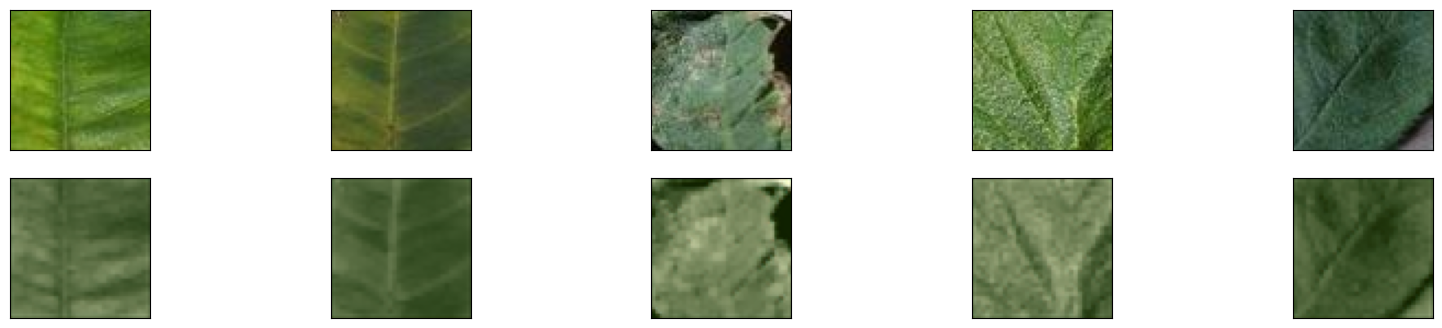

In [97]:
"""
-- Test image creation with autoencoder
"""

reconstructed_imgs = autoencoder.predict(X_test[:5])

print(mean_squared_error(X_test[0][0], reconstructed_imgs[0][0]))

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Clasificador B -> Pesos del autoencoder congelados

In [99]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = False 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

129/129 [==============================] - 1s 8ms/step


In [151]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.03, log=True)
    epochs = trial.suggest_int('epochs', 250, 450)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=epochs,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

[I 2023-06-13 14:57:27,337] A new study created in memory with name: no-name-c5b8d4f4-9b2f-4045-8b9d-de5ab047fed2


Beggining trial with lr=0.0022373958781730457 and epochs=361


[I 2023-06-13 15:30:26,224] Trial 0 finished with value: 0.2787642776966095 and parameters: {'lr': 0.0022373958781730457, 'epochs': 361}. Best is trial 0 with value: 0.2787642776966095.


Beggining trial with lr=0.006562970366616648 and epochs=263


[I 2023-06-13 15:54:15,767] Trial 1 finished with value: 0.29506203532218933 and parameters: {'lr': 0.006562970366616648, 'epochs': 263}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.0071067908269241255 and epochs=397


[I 2023-06-13 16:29:56,440] Trial 2 finished with value: 0.28144004940986633 and parameters: {'lr': 0.0071067908269241255, 'epochs': 397}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.021369648862464546 and epochs=397


[I 2023-06-13 17:05:13,682] Trial 3 finished with value: 0.2816832959651947 and parameters: {'lr': 0.021369648862464546, 'epochs': 397}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.006040940645104192 and epochs=388


[I 2023-06-13 17:39:06,742] Trial 4 finished with value: 0.2770615518093109 and parameters: {'lr': 0.006040940645104192, 'epochs': 388}. Best is trial 1 with value: 0.29506203532218933.


Beggining trial with lr=0.011054555482078874 and epochs=429


[I 2023-06-13 18:17:05,051] Trial 5 finished with value: 0.27365604043006897 and parameters: {'lr': 0.011054555482078874, 'epochs': 429}. Best is trial 1 with value: 0.29506203532218933.



Time taken to find best hyperparams: 11977.764578819275 s
Best Hyperparameters:  {'lr': 0.006562970366616648, 'epochs': 263}
Best Accuracy:  0.29506203532218933


In [153]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=600,
               batch_size=256,
               verbose=1)


Epoch 1/600


In [ ]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


129/129 [==============================] - 1s 8ms/step
[[  0   0   0 ...   3   0   0]
 [  0   2   0 ...   6   0   0]
 [  0   0   0 ...   5   0   0]
 ...
 [  0   0   0 ... 275   0   0]
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]]
Accuracy:  0.30625152031135977
Precision:  [0.         0.66666667 0.         0.55555556 0.11851852 0.33333333
 0.         0.         0.         0.         0.5        0.13333333
 0.31724138 0.         0.         0.56830601 0.51219512 0.5
 0.1        0.12       0.         0.         0.83870968 0.33333333
 0.27565084 0.         0.         0.         0.14335664 0.
 0.15830116 0.44444444 0.10714286 0.12337662 0.24       0.36279683
 0.         0.        ]
Recall:  [0.         0.04347826 0.         0.04065041 0.14159292 0.01265823
 0.         0.         0.         0.         0.01149425 0.02247191
 0.44230769 0.         0.         0.75544794 0.36627907 0.11111111
 0.04       0.02702703 0.         0.         0.53061224 0.03571429
 0.94240838 0.        

c:\Users\Juan Navarro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


General AUC: 0.643750780700428


#### Clasificador C -> Pesos del autoencoder sin congelar

In [ ]:
"""
Define encoder
"""
encoder = Model(input_img, latent)
encoder.trainable = True 
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

In [ ]:
"""
-- Analisis mejores hiperparámetros del clasificador --
"""

def objective(trial):

    # define hyperparameters to be optimized
    lr = trial.suggest_float('lr', 0.001, 0.03, log=True)
    epochs = trial.suggest_int('epochs', 250, 450)    

    print(f"Beggining trial with lr={lr} and epochs={epochs}")

    # Definir la arquitectura del clasificador utilizando el vector latente como entrada
    output = Flatten()(latent)
    output = Dense(128, activation='relu')(output)
    output = Dense(64, activation='relu')(output)
    output = Dense(38, activation='sigmoid')(output)

    # Crear el modelo del clasificador
    classifier = Model(latent, output)

    # Compilar el modelo del clasificador
    optimizer = Adam(learning_rate = lr)
    classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

    # Entrenar el clasificador utilizando el vector latente como características de entrada
    classifier.fit(encoded_train, y_train,
                epochs=epochs,
                batch_size=256,
                verbose=0)

    # Evaluar el rendimiento del clasificador en el conjunto de prueba
    _, accuracy = classifier.evaluate(encoded_test, y_test, verbose=0)

    return accuracy

# Create optuna study and optimize the objetive function
begin_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)
finish_time = time.time()

optuna_time = finish_time - begin_time
print(f"\nTime taken to find best hyperparams: {optuna_time} s")
# Print the best hyperparameters and the best objective value
best_params = study.best_params
best_value = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_value)

Epoch 1/50
91/91 [==============================] - 18s 184ms/step - loss: 0.2698 - accuracy: 0.0194 - val_loss: 0.1256 - val_accuracy: 0.1005
Epoch 2/50
91/91 [==============================] - 16s 177ms/step - loss: 0.1185 - accuracy: 0.1005 - val_loss: 0.1154 - val_accuracy: 0.1005
Epoch 3/50
91/91 [==============================] - 16s 178ms/step - loss: 0.1148 - accuracy: 0.0991 - val_loss: 0.1144 - val_accuracy: 0.1005
Epoch 4/50
91/91 [==============================] - 16s 179ms/step - loss: 0.1143 - accuracy: 0.0990 - val_loss: 0.1142 - val_accuracy: 0.1005
Epoch 5/50
91/91 [==============================] - 16s 179ms/step - loss: 0.1142 - accuracy: 0.1006 - val_loss: 0.1141 - val_accuracy: 0.1005
Epoch 6/50
36/91 [==========>...................] - ETA: 9s - loss: 0.1143 - accuracy: 0.1053

KeyboardInterrupt: 

In [ ]:
"""
-- Entrenamiento del modelo con los mejores hiperparámetros --
"""
# Definir la arquitectura del clasificador utilizando el vector latente como entrada
output = Flatten()(latent)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(38, activation='sigmoid')(output)

# Crear el modelo del clasificador
classifier = Model(latent, output)

# Compilar el modelo del clasificador
optimizer = Adam(learning_rate = best_params['lr'])
classifier.compile(optimizer='adam', loss='MSE', metrics=['accuracy'])

# Entrenar el clasificador utilizando el vector latente como características de entrada
classifier.fit(encoded_train, y_train,
               epochs=best_params['epochs'],
               batch_size=256,
               verbose=1)


In [ ]:
"""
-- Obtención de las métricas -- 
"""

predictions = classifier.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
#print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

for i in range(38):
    test_label_mat.append([])
    predictions_mat.append([])

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    for j in range(38):
        test_label_mat[j].append(real_values[i] == j)  
        predictions_mat[j].append(predictions[i] == j)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)


## Experimento 2